## 1. Importing Libraries

In [7]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
import matplotlib.pyplot as plt

## 2. Loading and Preprocessing Images

In [8]:
# Load images
image_normal = PIL.Image.open("./chest_Xray/train/NORMAL/IM-0115-0001.jpeg")

# Data generators with augmentation
training_generator = ImageDataGenerator(
    rescale=1/255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

validation_generator = ImageDataGenerator(rescale=1/255)
test_generator = ImageDataGenerator(rescale=1/255)
# Load the training data for the neural network
training_dir = "./chest_Xray/train/"
data_train = training_generator.flow_from_directory(
    training_dir,
    target_size=(120, 120),
    batch_size=8,
    class_mode="binary"
)

# Load the validation and test data for the neural network
valid_dir = "./chest_Xray/val/"
data_valid = validation_generator.flow_from_directory(
    valid_dir,
    target_size=(120, 120),
    batch_size=8,
    class_mode="binary"
)

test_dir = "./chest_Xray/test/"
data_test = test_generator.flow_from_directory(
    test_dir,
    target_size=(120, 120),
    batch_size=8,
    class_mode="binary"
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 3. Preparing Data for SVM


In [9]:
# Flatten the image data for SVM
X_train_svm = np.array([data_train[i][0][0].flatten() for i in range(len(data_train))])
y_train_svm = np.array([data_train[i][1][0] for i in range(len(data_train))])

X_valid_svm = np.array([data_valid[i][0][0].flatten() for i in range(len(data_valid))])
y_valid_svm = np.array([data_valid[i][1][0] for i in range(len(data_valid))])

X_test_svm = np.array([data_test[i][0][0].flatten() for i in range(len(data_test))])
y_test_svm = np.array([data_test[i][1][0] for i in range(len(data_test))])

## 4. Creating and Training SVM Model


In [10]:
# Create an SVM model
svm_model = make_pipeline(StandardScaler(), SVC(probability=True))

# Define an extended hyperparameter grid
param_grid = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__gamma': ['scale', 'auto'],
    'svc__class_weight': [None, 'balanced']
}

# Perform GridSearchCV to find the best hyperparameters
grid_search_svm = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train_svm, y_train_svm)

# Get the best model
best_svm_model = grid_search_svm.best_estimator_

## 5. Evaluating the Model


In [11]:
# Evaluate the SVM model on the test set
y_test_pred_svm = best_svm_model.predict(X_test_svm)
test_accuracy_svm = accuracy_score(y_test_svm, y_test_pred_svm)
test_precision_svm = precision_score(y_test_svm, y_test_pred_svm)
test_recall_svm = recall_score(y_test_svm, y_test_pred_svm)
test_auc_svm = roc_auc_score(y_test_svm, best_svm_model.predict_proba(X_test_svm)[:, 1])

print(f"SVM Test Accuracy: {test_accuracy_svm}")
print(f"SVM Test Precision: {test_precision_svm}")
print(f"SVM Test Recall: {test_recall_svm}")
print(f"SVM Test AUC: {test_auc_svm}")

SVM Test Accuracy: 0.8461538461538461
SVM Test Precision: 0.8333333333333334
SVM Test Recall: 0.9375
SVM Test AUC: 0.8944444444444444


## 6. Visualizing Predictions


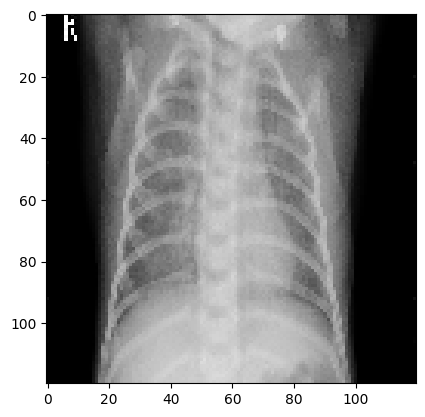

Probability of pneumonia in this image (SVM):  0.9999876577554854


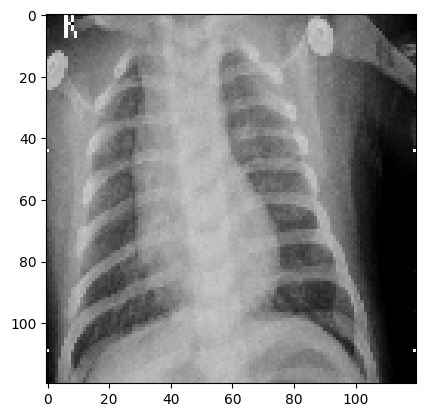

Probability of pneumonia in this image (SVM):  0.10449055049284066


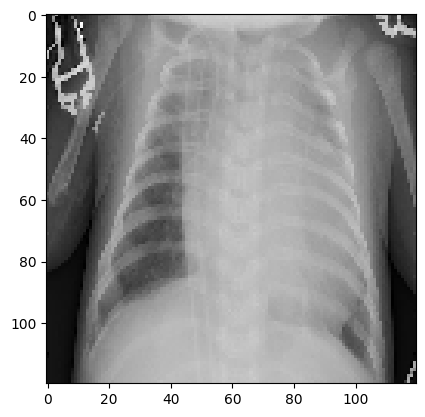

Probability of pneumonia in this image (SVM):  0.8088922637429481


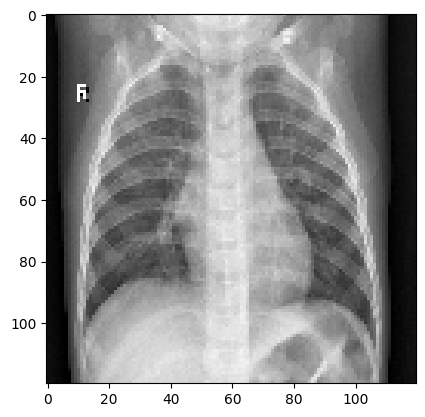

Probability of pneumonia in this image (SVM):  0.8436762226705301


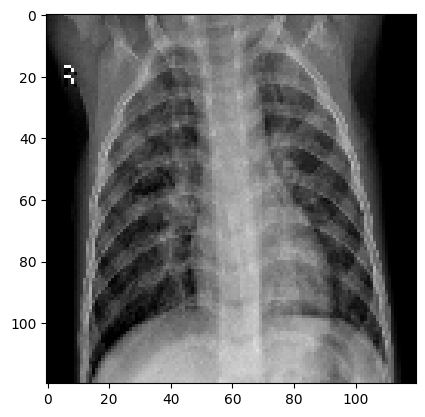

Probability of pneumonia in this image (SVM):  0.9999971086462885


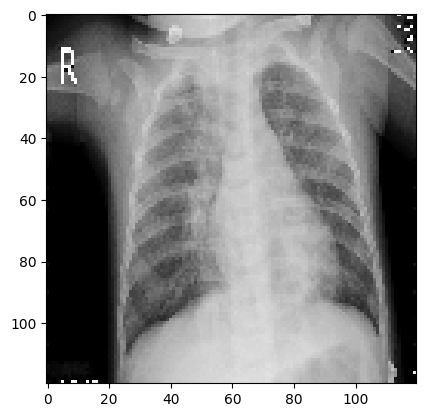

Probability of pneumonia in this image (SVM):  0.703220022073388


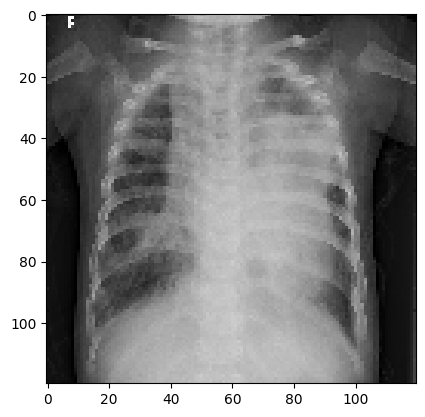

Probability of pneumonia in this image (SVM):  0.039522588398524926


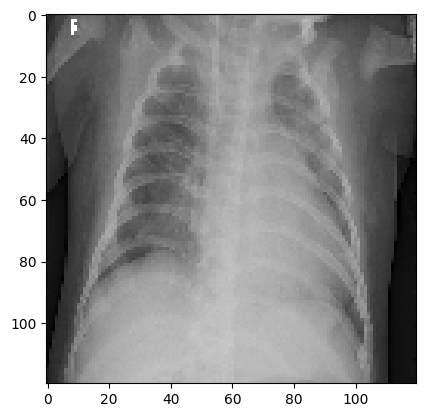

Probability of pneumonia in this image (SVM):  0.9932061940737057


In [12]:
# Display predictions on a batch from the test set
x, y = next(data_test)
predictions_svm = best_svm_model.predict_proba(X_test_svm)

# Display results
for j in range(8):
    plt.imshow(x[j])
    plt.show()
    print("Probability of pneumonia in this image (SVM): ", predictions_svm[j, 1])